<a href="https://colab.research.google.com/github/Daria-Lytvynenko/ML_course/blob/main/HW_2_2_%D0%9B%D0%BE%D0%B3%D1%96%D1%81%D1%82%D0%B8%D1%87%D0%BD%D0%B0_%D1%80%D0%B5%D0%B3%D1%80%D0%B5%D1%81%D1%96%D1%8F_%D0%B7_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu-course-c-2). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [37]:
from google.colab import drive
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, f1_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train=pd.read_csv('drive/MyDrive/ML_course/train.csv')
train.drop('CustomerId', axis=1, inplace=True)

In [4]:
train.head()

,id,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,Nwankwo,678.0,France,Male,29.0,4.0,0.00,3.0,1.0,0.0,180626.36,0.0
1,1,Ch'in,687.0,France,Female,34.0,1.0,0.00,2.0,0.0,1.0,63736.17,0.0
2,2,Thompson,682.0,France,Female,52.0,6.0,0.00,3.0,0.0,0.0,179655.87,1.0
3,3,Macleod,753.0,Germany,Male,44.0,6.0,83347.25,2.0,1.0,0.0,161407.48,0.0
4,4,Hsia,544.0,Germany,Female,55.0,0.0,107747.57,1.0,1.0,0.0,176580.86,1.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   Surname          15000 non-null  object 
 2   CreditScore      15000 non-null  float64
 3   Geography        15000 non-null  object 
 4   Gender           15000 non-null  object 
 5   Age              15000 non-null  float64
 6   Tenure           15000 non-null  float64
 7   Balance          15000 non-null  float64
 8   NumOfProducts    15000 non-null  float64
 9   HasCrCard        15000 non-null  float64
 10  IsActiveMember   15000 non-null  float64
 11  EstimatedSalary  15000 non-null  float64
 12  Exited           15000 non-null  float64
dtypes: float64(9), int64(1), object(3)
memory usage: 1.5+ MB


In [6]:
X=train.iloc[:,:-1]
y=train.Exited

In [7]:
train.Exited.value_counts(normalize=True)

,proportion
Exited,
0.0,0.796533
1.0,0.203467


In [8]:
X_train, X_val, y_train, y_val=train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [9]:
input_cols=train.iloc[:, :-1].columns
target_col=train.iloc[:,-1].name
train_inputs=X_train
val_inputs=X_val
train_targets=y_train
val_targets=y_val

3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [10]:
numeric_cols=train_inputs.select_dtypes(exclude='object').columns
categorical_cols=train_inputs.select_dtypes(include='object').columns

In [11]:
numeric_cols, categorical_cols

(Index(['id', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
        'HasCrCard', 'IsActiveMember', 'EstimatedSalary'],
       dtype='object'),
 Index(['Surname', 'Geography', 'Gender'], dtype='object'))

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

In [12]:
for i in categorical_cols:
  print(train[i].value_counts())

Surname
Ch'iu      252
Ch'ien     241
Ch'ang     225
Hsia       204
T'ien      187
          ... 
Trejo        1
Purdy        1
Otoole       1
Sarratt      1
Liardet      1
Name: count, Length: 764, dtype: int64
Geography
France     9032
Spain      3303
Germany    2665
Name: count, dtype: int64
Gender
Male      8529
Female    6471
Name: count, dtype: int64


In [13]:
enc=OneHotEncoder()
enc.fit(train_inputs[['Geography']])
geo_code_train=enc.transform(train_inputs[['Geography']]).toarray()
geo_code_val=enc.transform(val_inputs[['Geography']]).toarray()
train_inputs[enc.categories_[0]]=geo_code_train
val_inputs[enc.categories_[0]]=geo_code_val
enc.categories_

[array(['France', 'Germany', 'Spain'], dtype=object)]

In [14]:
enc=OneHotEncoder()
enc.fit(train_inputs[['Gender']])
gender_code_train=enc.transform(train_inputs[['Gender']]).toarray()
gender_code_val=enc.transform(val_inputs[['Gender']]).toarray()
train_inputs[enc.categories_[0]]=gender_code_train
val_inputs[enc.categories_[0]]=gender_code_val
enc.categories_

[array(['Female', 'Male'], dtype=object)]

In [15]:
from matplotlib import pyplot as plt
import seaborn as sns

In [16]:
df=train.select_dtypes(exclude='object').drop(['id', 'Exited'], axis=1)

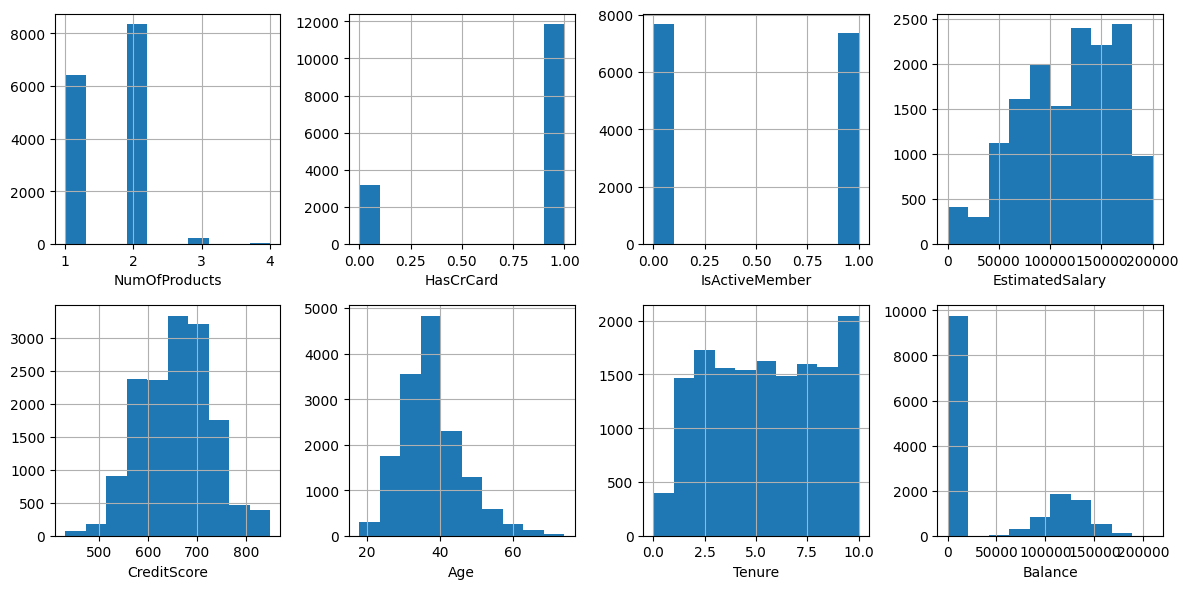

In [18]:
fig, axes=plt.subplots(nrows=2, ncols=4, figsize=(12,6))

for i, col in enumerate(df.columns):
  i=i-4
  c=i//4
  ax=axes[c,i]
  df[col].hist(ax=ax)
  ax.set_xlabel(col)

plt.tight_layout()
plt.show()

In [25]:
val_inputs=val_inputs.select_dtypes(exclude='object')

In [26]:
train_inputs=train_inputs.select_dtypes(exclude='object')

In [30]:
min_max_sc=MinMaxScaler()
min_max_sc.fit(train_inputs)
X_train_scaled=min_max_sc.transform(train_inputs)
X_val_scaled=min_max_sc.transform(val_inputs)

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [32]:
logr=LogisticRegression()
logr.fit(X_train_scaled, y_train)
y_pred_train=logr.predict(X_train_scaled)
y_pred_val=logr.predict(X_val_scaled)

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [35]:
confusion_matrix(y_train, y_pred_train)

array([[8603,  358],
       [1051, 1238]])

In [34]:
confusion_matrix(y_val, y_pred_val)

array([[2847,  140],
       [ 343,  420]])

In [38]:
f1_score(y_train, y_pred_train), f1_score(y_val, y_pred_val),

(0.6373230373230373, 0.6349206349206349)

In [41]:
roc_auc_score(y_train, y_pred_train), roc_auc_score(y_val, y_pred_val)

(0.7504483166679903, 0.7517944732986673)

In [42]:
roc_curve(y_train, y_pred_train)

(array([0.       , 0.0399509, 1.       ]),
 array([0.        , 0.54084753, 1.        ]),
 array([inf,  1.,  0.]))

In [43]:
?roc_curve

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [ ]:
import warnings
warnings.filterwarnings("ignore")

def predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]
    return prob

In [ ]:
predict_raw_df(scaler, encoder, numeric_cols, categorical_cols, raw_df[:5])

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.